## Inference: comparison of various models via information theoretic criteria

In the following, three models are compared based on some available noisy data:<br>
- a linear SDOF with viscous damping, <br>
- an elastoplastic SDOF with viscous damping, the nonlinear restoring force is $k x(t)$ if $x(t)<x_{n}$, $0$ otherwise, <br>
- a Bouc-Wen model of hysteresis without viscous damping (see parameter estimation problem). <br>

The capability of each model to represent the available data is assessed by computing an information theoretic criterion. The model that minimizes the criterion is the 'best' model given the data. Such analysis is performed within UQpy by calling the InfoModelSelection class of the Inference module.

In [1]:
# Basic imports
import numpy as np
import matplotlib.pyplot as plt

### Load the noisy data

The data (displacement time-series of a Bouc-Wen model of hysteresis with some viscous damping) was generated synthetically (see data_file in following cells). Results of the model selection analysis were also saved in a file (see results_file). In the following cells, the code necessary to run the estimation and save the results has been commented out, results are shown by loading the results_file.

In [2]:
# Set true parameters (used to generate the data) and scale of the input excitation
true_params = np.array([1.0, 2.5, 0.9, 3., 2.])
# Scale of the input excitation
scale = 0.1
# Files that contain the data / results of the model selection procedure
data_file = 'Data_noise[5%]_trueparams[{:.2f},{:.2f},{:.2f},{:.2f},{:.2f}]_scale[{:.2f}].txt'.format(
    true_params[0], true_params[1], true_params[2], true_params[3], true_params[4], scale)
results_file = 'Results_model_selection.pkl'
from utils_dynamics import load_results, save_results

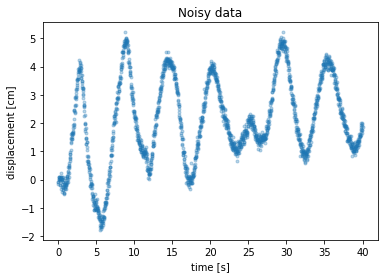

In [3]:
# Load data from saved file
from utils_dynamics import load_synthetic_data
data_noisy, variance_noise = load_synthetic_data(namefile=data_file)
time_vec = np.linspace(0., 0.02 * (len(data_noisy)-1), len(data_noisy))
            
# Visualize data time series
fig, ax = plt.subplots()
ax.plot(time_vec, data_noisy, linestyle='none', marker='.', alpha=0.3)
ax.set_title('Noisy data')
ax.set_xlabel('time [s]')
ax.set_ylabel('displacement [cm]')
plt.show()

### Define the various models for inference

Model Selection will be performed using information theoretic criterion, thus a prior is not required when defining the model. For each of the three models, lower bounds and upper bounds constraints are defined over the parameter space.

In [4]:
from UQpy.RunModel import RunModel
from UQpy.Inference import InferenceModel

In [5]:
# Bouc-Wen model of hysteresis
dyn_bw = RunModel(model_script='utils_dynamics.py', model_object_name='sdof_boucwen_RP', ntasks=4,
                  var_names=['$k$', '$r_{0}$', '$\delta$', '$n$'], scale_factor=scale)
inf_model_bw = InferenceModel(nparams=4, run_model_object=dyn_bw, error_covariance=variance_noise, 
                              name='BoucWen')
constraints_bw = {'type': 'ineq', 'fun': lambda x: np.concatenate(
    [x-np.array([0.5, 1., 0.55, 1.1]), np.array([3., 6., 6., 8.])-x], axis=0)}

In [6]:
# Elastoplastic model
dyn_elastoplastic = RunModel(model_script='utils_dynamics.py', model_object_name='sdof_elastoplastic_RP',
                                   var_names=['$k$', '$x_yield$', '$c$'], ntasks=4,
                                   scale_factor=scale, qois='time_disp')
inf_model_elastoplastic = InferenceModel(nparams=3, run_model_object=dyn_elastoplastic, 
                                         error_covariance=variance_noise, name='elastoplastic')
constraints_elastoplastic = {'type': 'ineq', 'fun': lambda x: np.concatenate(
    [x-np.array([0.5, 1., 0.2]), np.array([3., 6., 10.])-x], axis=0)}

In [7]:
# Linear model
dyn_linear = RunModel(model_script='utils_dynamics.py', model_object_name='sdof_linear_RP', 
                      var_names=['$k$', '$c$'], ntasks=4, scale_factor=scale, qois='time_disp', )
inf_model_linear = InferenceModel(nparams=2, run_model_object=dyn_linear, error_covariance=variance_noise,
                                  name='linear')
constraints_linear = {'type': 'ineq', 
                      'fun': lambda x: np.concatenate([x-np.array([0.5, 0.2]), np.array([3., 10.])-x], axis=0)}

Define the list of candidate models.

In [8]:
candidate_models = [inf_model_linear, inf_model_elastoplastic, inf_model_bw]

### Run Model Selection
 
First, instantiate the InfoModelSelection object. For each model, an optimizer and its arguments can be defined by the user, they must be passed to InfoModelSelection as lists of length the number of models.

In [9]:
# For each model, define the optimizer and its arguments niter_success and minimizer_kwargs
from scipy.optimize import basinhopping
optimizer = [basinhopping] * 3
niter_success = [15, 15, 10]
minimizer_kwargs = [{'constraints': c} for c in [constraints_linear, constraints_elastoplastic, constraints_bw]]

In [10]:
# Instantiate InfoModelSelection object
from UQpy.Inference import InfoModelSelection
selector = InfoModelSelection(candidate_models=candidate_models, data=data_noisy,
                              optimizer=optimizer, niter_success=niter_success, minimizer_kwargs=minimizer_kwargs,
                              sorted_outputs=False)

Run the estimation by providing a starting point for each model.

In [11]:
# Run Model Selection and save to a file
#x0 = [[1.7, 1.], [1.7, 3.2, 1.], [1.7, 3.2, 3.3, 5.5]]
#selector.run_estimation(x0=x0)
#for i, inf_model in enumerate(candidate_models):
#    save_results(namefile=results_file, key='mle_'+inf_model.name, 
#                 value=selector.ml_estimators[i].mle)
#    save_results(namefile=results_file, key='prob_'+inf_model.name, 
#                 value=selector.probabilities[i])
#    save_results(namefile=results_file, key='criterion_'+inf_model.name, 
#                 value=selector.criterion_values[i])

# Load file and print results
mles, probas, criteria = [], [], []
for i, inf_model in enumerate(candidate_models):
    print('Model: '+inf_model.name)
    mles.append(load_results(namefile=results_file, key='mle_'+inf_model.name))
    print('Maximum likelihood parameter estimate:')
    print(mles[-1])
    criteria.append(load_results(namefile=results_file, key='criterion_'+inf_model.name))
    print('AIC value: {}'.format(criteria[-1]))
    probas.append(load_results(namefile=results_file, key='prob_'+inf_model.name))
    print('Probability: {}\n'.format(probas[-1]))

Model: linear
Maximum likelihood parameter estimate:
[ 1.0160341  10.69415026]
AIC value: 796123.3971664653
Probability: 0.0

Model: elastoplastic
Maximum likelihood parameter estimate:
[ 0.97142659  2.11138086 10.        ]
AIC value: 1782.0742708465223
Probability: 0.0

Model: BoucWen
Maximum likelihood parameter estimate:
[0.99874625 2.65146839 1.03224508 2.65229985]
AIC value: -2402.5186173905317
Probability: 1.0



Run the estimation using the ML estimate for each model, provides a qualitative assessment of each model capability to fit the data.

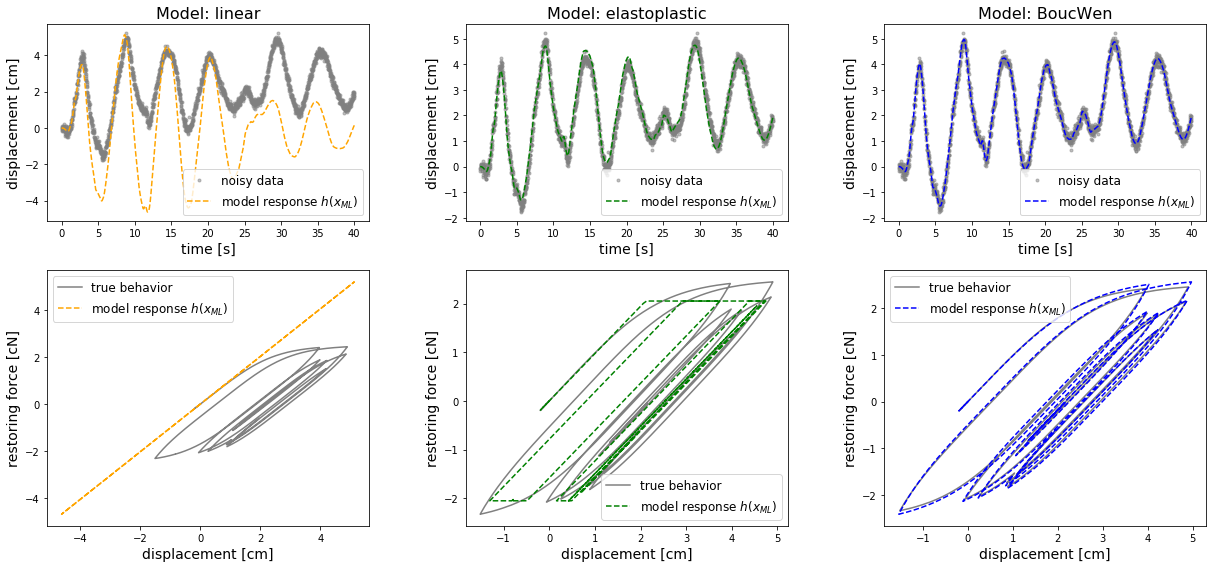

In [13]:
# Compare runs with the various models
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(17, 8.),  gridspec_kw={'height_ratios': [1, 1.3]})
colors = ['orange', 'green', 'blue']

true_response = RunModel(model_script='utils_dynamics.py', model_object_name='sdof_boucwen_RP', scale_factor=scale,
                         return_Rf=True, samples=true_params.reshape((1, -1))).qoi_list[0]
for i, model_object_name in enumerate(['sdof_linear_RP', 'sdof_elastoplastic_RP', 'sdof_boucwen_RP']):
    response = RunModel(model_script='utils_dynamics.py', model_object_name=model_object_name, scale_factor=scale,
                        return_Rf=True, samples=mles[i].reshape((1, -1))).qoi_list[0]
    ax[0][i].plot(time_vec, data_noisy, color='grey', linestyle='none', marker='.', alpha=0.5, label='noisy data')
    ax[0][i].plot(time_vec, response[0], color=colors[i], linestyle='--', label='model response $h(x_{ML})$')
    ax[0][i].set_ylabel('displacement [cm]', fontsize=14)
    ax[0][i].set_xlabel('time [s]', fontsize=14)
    ax[0][i].legend(fontsize=12)
    ax[0][i].set_title('Model: '+candidate_models[i].name, fontsize=16)
    
    ax[1][i].plot(true_response[0], true_response[1], color='grey', label='true behavior')
    ax[1][i].plot(response[0], response[1], color=colors[i], linestyle='--', label='model response $h(x_{ML})$')
    ax[1][i].set_xlabel('displacement [cm]', fontsize=14)
    ax[1][i].set_ylabel('restoring force [cN]', fontsize=14)
    ax[1][i].legend(fontsize=12)
    
fig.tight_layout()
fig.subplots_adjust(wspace = 0.3)
fig.savefig('model_selection.pdf')
plt.show(fig)